In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import RBFSampler
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')

# 1. SETUP: Generate Sample Data
#np.random.seed(42)
#X_normal = np.random.normal(size=(500, 2))
#X_outliers = np.random.uniform(low=-10, high=10, size=(15, 2))
#X = np.r_[X_normal, X_outliers]

# Standardize data (crucial for SVM and Elliptic Envelope)


df = pd.read_csv('D:\Manas PhD Den\CoderProducvity\Research_Papers\Data\Input_Data_Updated_Except_CMG_900_Series_2017_2019_2.csv')
cols = ['IP_RIW','ELS_DAYS']
X = df[cols]
X_scaled = StandardScaler().fit_transform(X)


In [72]:
# 2. INITIALIZE THE COMMITTEE
contamination_rate = 0.0125
feature_map = RBFSampler(gamma=0.1, random_state=42)
models = {
    "IsoForest": IsolationForest(contamination=contamination_rate, random_state=42),
    "LOF": LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=contamination_rate),
    "OneClassSVM": OneClassSVM(nu=contamination_rate, kernel="rbf", gamma=0.1),
    "EllipticEnv": EllipticEnvelope(contamination=contamination_rate, random_state=42),
    "SGDOneClassSVM": SGDOneClassSVM(nu=0.0125,shuffle=True,fit_intercept=True, random_state=42)
}

In [73]:

# 3. CONSTRUCT THE SCOREBOARD
score_df = pd.DataFrame(index=range(len(X)))

for name, model in models.items():
    model.fit(X_scaled)
    # Get decision function scores (inverting so higher = more anomalous)
    if name == "LOF":
        score_df[name] = -model.decision_function(X_scaled)
    else:
        score_df[name] = -model.decision_function(X_scaled)


In [74]:

# 4. NORMALIZE AND CALCULATE ENSEMBLE CONFIDENCE
scaler = MinMaxScaler()
norm_scores = scaler.fit_transform(score_df)
norm_df = pd.DataFrame(norm_scores, columns=[f"{n}_Norm" for n in models.keys()])

# High Confidence = Average Score across all 4 models
score_df['Master_Confidence'] = norm_df.mean(axis=1)

# Consensus Measure = How many models flagged this as a top-5% anomaly?
# (Using 0.8 as a normalized threshold for 'flagged')
score_df['Agreement_Count'] = (norm_df > 0.75).sum(axis=1)


In [75]:
norm_df

,IsoForest_Norm,LOF_Norm,OneClassSVM_Norm,EllipticEnv_Norm,SGDOneClassSVM_Norm
0,0.236116,3.465921e-11,0.023944,9.281569e-06,0.771596
1,0.242426,2.084121e-11,0.010059,1.262822e-05,0.774807
2,0.212282,2.084121e-11,0.017564,8.710590e-06,0.773554
3,0.433191,2.655416e-11,0.021299,8.829565e-05,0.749083
4,0.676061,8.912529e-11,0.078988,1.767611e-04,0.627282
...,...,...,...,...,...
508182,0.113083,2.084121e-11,0.087126,1.567971e-06,0.852994
508183,0.021604,2.084121e-11,0.088090,3.637736e-07,0.848422
508184,0.047702,2.084121e-11,0.084480,7.954543e-07,0.844017
508185,0.279418,2.084121e-11,0.014909,1.677502e-05,0.761171


In [76]:
score_df

,IsoForest,LOF,OneClassSVM,EllipticEnv,SGDOneClassSVM,Master_Confidence,Agreement_Count
0,-0.242754,-3.950912e+07,-109.027643,-1380.328001,-0.000109,0.206333,1
1,-0.239628,-3.950912e+07,-127.480904,-1373.147618,-0.000108,0.205461,1
2,-0.254561,-3.950912e+07,-117.506336,-1381.553064,-0.000109,0.200682,1
3,-0.145128,-3.950912e+07,-112.542379,-1210.799736,-0.000120,0.240732,0
4,-0.024815,-3.950912e+07,-35.871421,-1020.993117,-0.000178,0.276502,0
...,...,...,...,...,...,...,...
508182,-0.303702,-3.950912e+07,-25.054581,-1396.877874,-0.000071,0.210641,1
508183,-0.349019,-3.950912e+07,-23.774194,-1399.461534,-0.000073,0.191623,1
508184,-0.336090,-3.950912e+07,-28.571237,-1398.535344,-0.000075,0.195240,1
508185,-0.221303,-3.950912e+07,-121.035712,-1364.250462,-0.000114,0.211103,1


In [77]:
# 5. FILTER FOR HIGH CONFIDENCE
# Criteria: Average score is high AND at least 3 out of 4 models agree
threshold = score_df['Master_Confidence'].mean() + (3 * score_df['Master_Confidence'].std())



In [78]:
threshold

0.2828140940724215

In [79]:
final_dataset = pd.concat([pd.DataFrame(X, columns=['IP_RIW', 'ELS_DAYS']), score_df], axis=1)
high_conf_anomalies = final_dataset[
    (final_dataset['Master_Confidence'] > threshold) & 
    (final_dataset['Agreement_Count'] >= 3)
].sort_values(by='Master_Confidence', ascending=False)


In [80]:
len(high_conf_anomalies)

158

Detected 158 anomalies with 5 model consensus.
          IP_RIW  ELS_DAYS  Master_Confidence  Agreement_Count
298352  326.0779      42.5           0.738956                3
136288  250.6961       7.2           0.690801                3
474586  249.0458       6.3           0.690364                3
214700  223.4254      20.1           0.648171                3
64      233.3529      31.3           0.642869                3


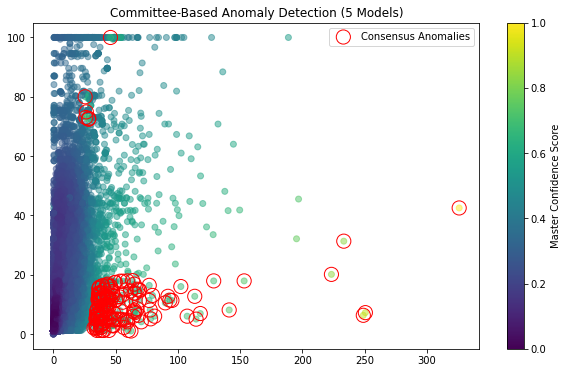

In [81]:
# 6. OUTPUT & VISUALIZATION
print(f"Detected {len(high_conf_anomalies)} anomalies with 5 model consensus.")
print(high_conf_anomalies[['IP_RIW', 'ELS_DAYS', 'Master_Confidence', 'Agreement_Count']].head())

plt.figure(figsize=(10, 6))
plt.scatter(X['IP_RIW'], X['ELS_DAYS'], c=score_df['Master_Confidence'], cmap='viridis', alpha=0.5)
plt.scatter(high_conf_anomalies['IP_RIW'], high_conf_anomalies['ELS_DAYS'], 
            edgecolors='red', facecolors='none', s=200, label='Consensus Anomalies')
plt.title("Committee-Based Anomaly Detection (5 Models)")
plt.colorbar(label="Master Confidence Score")
plt.legend()
plt.show()

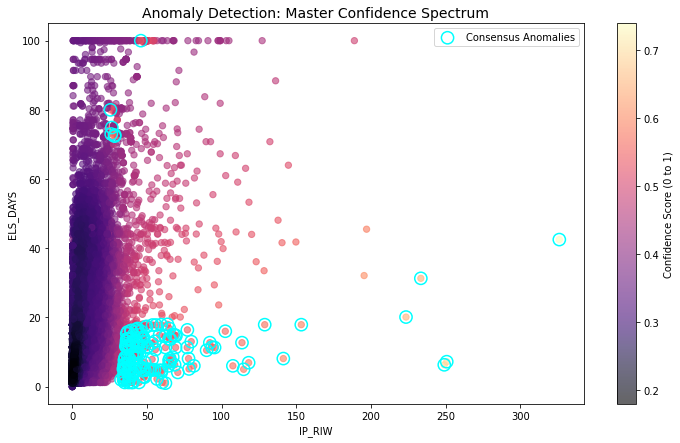

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

# Using 'magma' for a high-contrast dark-to-bright spectrum
# Other options: 'plasma', 'inferno', 'cividis', or 'RdYlBu_r'
scatter = plt.scatter(X['IP_RIW'], X['ELS_DAYS'], 
                      c=score_df['Master_Confidence'], 
                      cmap='magma', 
                      alpha=0.6, 
                      s=40)

# Highlight anomalies
plt.scatter(high_conf_anomalies['IP_RIW'], high_conf_anomalies['ELS_DAYS'], 
            edgecolors='cyan', # Cyan provides great contrast against dark magma colors
            facecolors='none', 
            linewidths=1.5,
            s=150, 
            label='Consensus Anomalies')

plt.title("Anomaly Detection: Master Confidence Spectrum", fontsize=14)
plt.xlabel("IP_RIW")
plt.ylabel("ELS_DAYS")

# Adding the colorbar to show the scale
cbar = plt.colorbar(scatter)
cbar.set_label('Confidence Score (0 to 1)')

plt.legend()
plt.show()

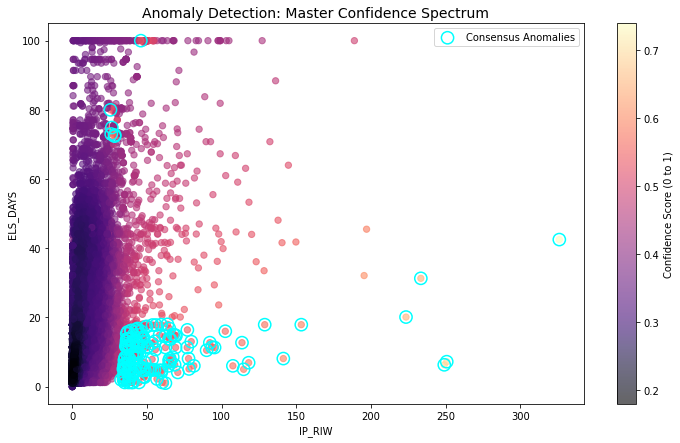

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

# Using 'magma' for a high-contrast dark-to-bright spectrum
# Other options: 'plasma', 'inferno', 'cividis', or 'RdYlBu_r'
scatter = plt.scatter(X['IP_RIW'], X['ELS_DAYS'], 
                      c=score_df['Master_Confidence'], 
                      cmap='magma', 
                      alpha=0.6, 
                      s=40)

# Highlight anomalies
plt.scatter(high_conf_anomalies['IP_RIW'], high_conf_anomalies['ELS_DAYS'], 
            edgecolors='cyan', # Cyan provides great contrast against dark magma colors
            facecolors='none', 
            linewidths=1.5,
            s=150, 
            label='Consensus Anomalies')

plt.title("Anomaly Detection: Master Confidence Spectrum", fontsize=14)
plt.xlabel("IP_RIW")
plt.ylabel("ELS_DAYS")

# Adding the colorbar to show the scale
cbar = plt.colorbar(scatter)
cbar.set_label('Confidence Score (0 to 1)')

plt.legend()
plt.show()

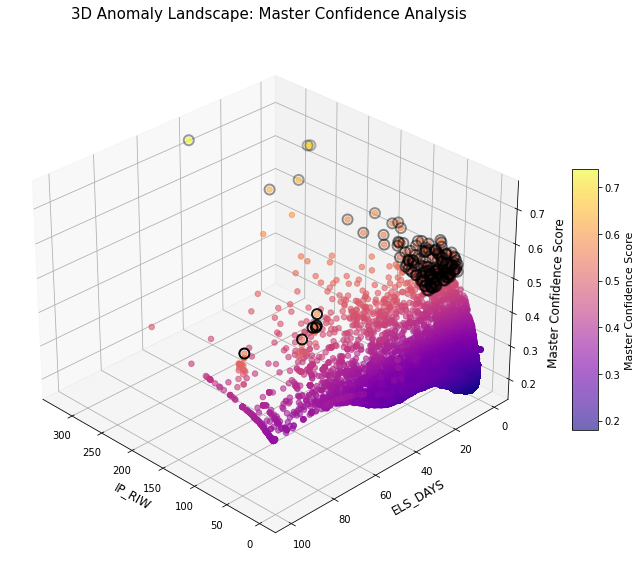

In [84]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting with the exact variable name "Master Confidence"
scatter = ax.scatter(X['IP_RIW'], X['ELS_DAYS'], score_df['Master_Confidence'],
                     c=score_df['Master_Confidence'], cmap='plasma', 
                     alpha=0.6, s=30, label='Data Points')

# Highlight anomalies
ax.scatter(high_conf_anomalies['IP_RIW'], high_conf_anomalies['ELS_DAYS'], 
           high_conf_anomalies['Master_Confidence'],
           edgecolors='black', facecolors='none', linewidths=2, s=100, label='Consensus Anomalies')

# Corrected labels
ax.set_title("3D Anomaly Landscape: Master Confidence Analysis", fontsize=15, pad=20)
ax.set_xlabel("IP_RIW", fontsize=12)
ax.set_ylabel("ELS_DAYS", fontsize=12)
ax.set_zlabel("Master Confidence Score", fontsize=12) # Corrected here

# Corrected Colorbar label
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Master Confidence Score', fontsize=11) # Corrected here

ax.view_init(elev=30, azim=135)
plt.tight_layout()
plt.show()